# Random undersampling based ROC-like curve (PneumoniaMNIST)

In [1]:
# for dterministic=True
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import medmnist
print(medmnist.__version__)

3.0.2


In [3]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [5]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


### Function for generating a dataset

In [6]:
from torch.utils.data import Subset

# Number of positive samples needed
pos_samples = 5
np.random.seed(42)


def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    labels = train_dataset.labels.flatten()

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # 3. Create the new subset dataset using the combined indices
    new_train_dataset = Subset(train_dataset, final_indices)


    # --- Verification (Optional) ---
    # You can verify the composition of your new dataset

    new_labels = labels[final_indices]
    num_positive = np.sum(new_labels == 1)
    num_negative = np.sum(new_labels == 0)

    print(f"Original dataset size: {len(train_dataset)}")
    print(f"New dataset size: {len(new_train_dataset)}")
    print("-" * 30)
    print(f"Original dataset labels distribution:")
    print(f"Original positive samples (pneumonia): {num_orig_positive}")
    print(f"Original negative samples (normal): {num_orig_negative}")
    print(f"Samples in new dataset:")
    print(f"  - Positive (pneumonia): {num_positive}")
    print(f"  - Negative (normal):    {num_negative}")
    print(f"  - Total:                {len(new_labels)}")

    return new_train_dataset





### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS



In [7]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 10
NUM_WORKERS = 4

### Create the SequentialNN classifier class

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x


## Lightning Module

In [9]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Plot ROC curve

In [10]:
import matplotlib.pyplot as plt

def plot_combined_roc_curves(results_list):
    plt.figure(figsize=(8, 8))
    
    for result in results_list:
        plt.plot(result["fpr"], result["tpr"], lw=2, 
                 label=f'{result["name"]} (area = {result["auc"]:.2f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

In [11]:
# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### Train the classifiers for all sample_ratios

In [12]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---

# 1. Get original class counts from your train_dataset
try:
    original_labels = np.array(train_dataset.labels).flatten()
except AttributeError:
    original_labels = np.array(train_dataset.targets).flatten()

original_counts = Counter(original_labels)
num_pos_original = original_counts.get(1, 0)  # e.g., 3494 (Pneumonia)
num_neg_original = original_counts.get(0, 0)  # e.g., 1214 (Normal)

# The pivot point for your function's logic
orig_sample_ratio = num_pos_original / num_neg_original # ~2.88

# 2. Define how many steps for each regime
N_POINTS_PER_REGIME = 50  # You can change this

# 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
# This will test scenarios from extreme negative-class dominance up to the original balance.
print("Generating ratios for Regime 1 (target ratio < 2.88)...")
ratios_regime1 = np.geomspace(
    start=0.001,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
    stop=orig_sample_ratio,         # Go up to the original ratio
    num=N_POINTS_PER_REGIME,
    endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
)

# 4. Generate ratios for Regime 2 (from the pivot up to 3494)
# This will test scenarios from the original balance up to extreme positive-class dominance.
print("Generating ratios for Regime 2 (target ratio > 2.88)...")
ratios_regime2 = np.geomspace(
    start=orig_sample_ratio, # Start just above the pivot
    stop=3494,                      # Your specified upper limit
    num=N_POINTS_PER_REGIME
)

# 5. Combine, sort, and create the final list for the loop
#    We also add the original ratio to ensure we have a baseline run.
all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
print("First few ratios:", np.round(all_ratios[:5], 3))
print("Last few ratios:", np.round(all_ratios[-5:], 2))

Generating ratios for Regime 1 (target ratio < 2.88)...
Generating ratios for Regime 2 (target ratio > 2.88)...

Generated 101 unique sample ratios to test.
First few ratios: [0.001 0.001 0.001 0.002 0.002]
Last few ratios: [1956.82 2262.   2614.79 3022.59 3494.  ]


In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# --- Create the model ONCE, before the loop starts ---
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# --- Start the main experimental loop ---
for i, sample_ratio in enumerate(all_ratios):
    print("="*60)
    print(f"--- STARTING STAGE {i+1} FOR SAMPLE RATIO: {sample_ratio} ---")
    print("="*60)
    
    # 1. Create the specific dataloader for this stage
    undersampled_train_dataset = undersample_dataset(train_dataset, sample_ratio)
    undersampled_train_loader = data.DataLoader(undersampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    # 2. Instantiate a NEW checkpoint callback for this specific stage
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'checkpoints/stage_{i+1}/',
        filename=f'best-model-{{epoch:02d}}-{{val_acc:.2f}}',
        save_top_k=1,
        mode='max',
    )
    
    # 3. Instantiate a NEW Trainer for this specific stage
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        #strategy='ddp_notebook',
        max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_ratio_{sample_ratio}"),
        precision='16-mixed'
        )
    
    # 4. Train the model. It will start with weights from the previous stage.
    trainer.fit(model, train_dataloaders=undersampled_train_loader, val_dataloaders=val_loader)
    
    # 5. Get the path to the best model from THIS stage and store it
    if checkpoint_callback.best_model_path:
        best_path_this_stage = checkpoint_callback.best_model_path
        print(f"--- Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
        best_model_paths.append(best_path_this_stage)
        
        # 6. CRITICAL: Load the best weights back into the model object
        # This ensures we carry forward the BEST model to the next stage, not the last.
        print(f"Loading best weights from {best_path_this_stage} to continue...")
        model = LitSimpleCNN.load_from_checkpoint(best_path_this_stage)
    else:
        print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
        # If no checkpoint was saved, the model object will just have the weights from the last epoch.

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.001 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s, v_num=2, train_loss_step=0.000, train_acc_step=1.000, val_loss=19.60, val_acc=0.258, val_auc=0.530, train_loss_epoch=0.00545, train_acc_epoch=0.999]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s, v_num=2, train_loss_step=0.000, train_acc_step=1.000, val_loss=19.60, val_acc=0.258, val_auc=0.530, train_loss_epoch=0.00545, train_acc_epoch=0.999]
--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v7.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v7.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.0011726869285444514 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215
Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 14.82it/s, v_num=0, train_loss_step=3.41e-6, train_acc_step=1.000, val_loss=20.90, val_acc=0.258, val_auc=0.616, train_loss_epoch=0.0138, train_acc_epoch=0.999]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 14.72it/s, v_num=0, train_loss_step=3.41e-6, train_acc_step=1.000, val_loss=20.90, val_acc=0.258, val_auc=0.616, train_loss_epoch=0.0138, train_acc_epoch=0.999]
--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.0013751946323790195 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215
Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s, v_num=0, train_loss_step=0.00324, train_acc_step=1.000, val_loss=4.240, val_acc=0.258, val_auc=0.865, train_loss_epoch=0.00648, train_acc_epoch=0.999] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s, v_num=0, train_loss_step=0.00324, train_acc_step=1.000, val_loss=4.240, val_acc=0.258, val_auc=0.865, train_loss_epoch=0.00648, train_acc_epoch=0.999]
--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.0016126727695953687 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215
Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 14.08it/s, v_num=0, train_loss_step=0.000169, train_acc_step=1.000, val_loss=5.600, val_acc=0.258, val_auc=0.806, train_loss_epoch=0.00949, train_acc_epoch=0.999]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 13.96it/s, v_num=0, train_loss_step=0.000169, train_acc_step=1.000, val_loss=5.600, val_acc=0.258, val_auc=0.806, train_loss_epoch=0.00949, train_acc_epoch=0.999]
--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.0018911602769240668 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1216
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2
  - Negative (normal):    1214
  - Total:                1216
Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 13.26it/s, v_num=0, train_loss_step=5.38e-5, train_acc_step=1.000, val_loss=4.060, val_acc=0.258, val_auc=0.819, train_loss_epoch=0.0815, train_acc_epoch=0.998]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 13.21it/s, v_num=0, train_loss_step=5.38e-5, train_acc_step=1.000, val_loss=4.060, val_acc=0.258, val_auc=0.819, train_loss_epoch=0.0815, train_acc_epoch=0.998]
--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.0022177389365313606 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1216
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2
  - Negative (normal):    1214
  - Total:                1216
Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 13.10it/s, v_num=0, train_loss_step=0.00145, train_acc_step=1.000, val_loss=3.500, val_acc=0.258, val_auc=0.860, train_loss_epoch=0.00869, train_acc_epoch=0.998]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 19/19 [00:01<00:00, 13.01it/s, v_num=0, train_loss_step=0.00145, train_acc_step=1.000, val_loss=3.500, val_acc=0.258, val_auc=0.860, train_loss_epoch=0.00869, train_acc_epoch=0.998]
--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.002600713461794397 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1217
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    1214
  - Total:                1217


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.28it/s, v_num=0, train_loss_step=2.67e-5, train_acc_step=1.000, val_loss=4.930, val_acc=0.258, val_auc=0.801, train_loss_epoch=0.0298, train_acc_epoch=0.998] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s, v_num=0, train_loss_step=2.67e-5, train_acc_step=1.000, val_loss=4.930, val_acc=0.258, val_auc=0.801, train_loss_epoch=0.0298, train_acc_epoch=0.998]
--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.0030498226815358826 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1217
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3
  - Negative (normal):    1214
  - Total:                1217
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=20.10, val_acc=0.258, val_auc=0.685, train_loss_epoch=0.00147, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=20.10, val_acc=0.258, val_auc=0.685, train_loss_epoch=0.00147, train_acc_epoch=1.000]
--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=08-val_acc=0.34.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=08-val_acc=0.34.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.003576487193015517 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1218
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 4
  - Negative (normal):    1214
  - Total:                1218
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.65it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=3.850, val_acc=0.361, val_auc=0.933, train_loss_epoch=0.0113, train_acc_epoch=0.998]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=3.850, val_acc=0.361, val_auc=0.933, train_loss_epoch=0.0113, train_acc_epoch=0.998]
--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=09-val_acc=0.36.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=09-val_acc=0.36.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 10 FOR SAMPLE RATIO: 0.004194099781355934 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1219
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 5
  - Negative (normal):    1214
  - Total:                1219
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.25it/s, v_num=0, train_loss_step=8.23e-5, train_acc_step=1.000, val_loss=3.000, val_acc=0.527, val_auc=0.963, train_loss_epoch=0.00782, train_acc_epoch=0.997]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s, v_num=0, train_loss_step=8.23e-5, train_acc_step=1.000, val_loss=3.000, val_acc=0.527, val_auc=0.963, train_loss_epoch=0.00782, train_acc_epoch=0.997]
--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=09-val_acc=0.53.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=09-val_acc=0.53.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 11 FOR SAMPLE RATIO: 0.004918365990607246 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1219
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 5
  - Negative (normal):    1214
  - Total:                1219
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.41it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=7.560, val_acc=0.594, val_auc=0.882, train_loss_epoch=9.87e-6, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.37it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=7.560, val_acc=0.594, val_auc=0.882, train_loss_epoch=9.87e-6, train_acc_epoch=1.000]
--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=02-val_acc=0.64.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=02-val_acc=0.64.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 12 FOR SAMPLE RATIO: 0.0057677035069827 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1221
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 7
  - Negative (normal):    1214
  - Total:                1221
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.45it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=4.970, val_acc=0.674, val_auc=0.930, train_loss_epoch=1.69e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.41it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=4.970, val_acc=0.674, val_auc=0.930, train_loss_epoch=1.69e-5, train_acc_epoch=1.000]
--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=03-val_acc=0.81.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=03-val_acc=0.81.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 13 FOR SAMPLE RATIO: 0.0067637105103586035 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1222
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    1214
  - Total:                1222
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.02it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=5.060, val_acc=0.666, val_auc=0.920, train_loss_epoch=1.78e-6, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.95it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=5.060, val_acc=0.666, val_auc=0.920, train_loss_epoch=1.78e-6, train_acc_epoch=1.000]
--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=04-val_acc=0.69.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=04-val_acc=0.69.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 14 FOR SAMPLE RATIO: 0.007931714903956257 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1223
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 9
  - Negative (normal):    1214
  - Total:                1223
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.400, val_acc=0.706, val_auc=0.973, train_loss_epoch=0.000165, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 13.32it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.400, val_acc=0.706, val_auc=0.973, train_loss_epoch=0.000165, train_acc_epoch=1.000]
--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=02-val_acc=0.76.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=02-val_acc=0.76.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 15 FOR SAMPLE RATIO: 0.009301418388810712 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1225
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 11
  - Negative (normal):    1214
  - Total:                1225
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s, v_num=0, train_loss_step=3.18e-7, train_acc_step=1.000, val_loss=3.110, val_acc=0.740, val_auc=0.958, train_loss_epoch=7.9e-6, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.74it/s, v_num=0, train_loss_step=3.18e-7, train_acc_step=1.000, val_loss=3.110, val_acc=0.740, val_auc=0.958, train_loss_epoch=7.9e-6, train_acc_epoch=1.000]
--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=05-val_acc=0.81.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=05-val_acc=0.81.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 16 FOR SAMPLE RATIO: 0.01090765176148132 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1227
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 13
  - Negative (normal):    1214
  - Total:                1227
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.93it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.650, val_acc=0.771, val_auc=0.962, train_loss_epoch=1.58e-5, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.90it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.650, val_acc=0.771, val_auc=0.962, train_loss_epoch=1.58e-5, train_acc_epoch=1.000]
--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.89.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.89.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 17 FOR SAMPLE RATIO: 0.012791260641804005 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1229
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 15
  - Negative (normal):    1214
  - Total:                1229
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.54it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.720, val_acc=0.788, val_auc=0.963, train_loss_epoch=2.88e-6, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.47it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.720, val_acc=0.788, val_auc=0.963, train_loss_epoch=2.88e-6, train_acc_epoch=1.000]
--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=04-val_acc=0.82.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=04-val_acc=0.82.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 18 FOR SAMPLE RATIO: 0.01500014415424867 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1232
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 18
  - Negative (normal):    1214
  - Total:                1232
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.98it/s, v_num=0, train_loss_step=0.000137, train_acc_step=1.000, val_loss=1.380, val_acc=0.803, val_auc=0.980, train_loss_epoch=6.1e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.94it/s, v_num=0, train_loss_step=0.000137, train_acc_step=1.000, val_loss=1.380, val_acc=0.803, val_auc=0.980, train_loss_epoch=6.1e-5, train_acc_epoch=1.000]
--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.85.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.85.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 19 FOR SAMPLE RATIO: 0.01759047297596988 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1235
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 21
  - Negative (normal):    1214
  - Total:                1235
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.53it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.520, val_acc=0.803, val_auc=0.963, train_loss_epoch=3.74e-5, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.50it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=2.520, val_acc=0.803, val_auc=0.963, train_loss_epoch=3.74e-5, train_acc_epoch=1.000]
--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=04-val_acc=0.87.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=04-val_acc=0.87.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 20 FOR SAMPLE RATIO: 0.020628117725834307 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1239
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 25
  - Negative (normal):    1214
  - Total:                1239
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.23it/s, v_num=0, train_loss_step=2.36e-6, train_acc_step=1.000, val_loss=2.180, val_acc=0.782, val_auc=0.965, train_loss_epoch=0.000209, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.20it/s, v_num=0, train_loss_step=2.36e-6, train_acc_step=1.000, val_loss=2.180, val_acc=0.782, val_auc=0.965, train_loss_epoch=0.000209, train_acc_epoch=1.000]
--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=05-val_acc=0.87.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=05-val_acc=0.87.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 21 FOR SAMPLE RATIO: 0.024190324017561993 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1243
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 29
  - Negative (normal):    1214
  - Total:                1243
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.26it/s, v_num=0, train_loss_step=2.47e-7, train_acc_step=1.000, val_loss=2.260, val_acc=0.782, val_auc=0.971, train_loss_epoch=0.000232, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.20it/s, v_num=0, train_loss_step=2.47e-7, train_acc_step=1.000, val_loss=2.260, val_acc=0.782, val_auc=0.971, train_loss_epoch=0.000232, train_acc_epoch=1.000]
--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=06-val_acc=0.85.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=06-val_acc=0.85.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 22 FOR SAMPLE RATIO: 0.02836767677264985 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1248
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 34
  - Negative (normal):    1214
  - Total:                1248
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.86it/s, v_num=0, train_loss_step=0.0109, train_acc_step=1.000, val_loss=0.726, val_acc=0.853, val_auc=0.982, train_loss_epoch=0.0162, train_acc_epoch=0.995]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.82it/s, v_num=0, train_loss_step=0.0109, train_acc_step=1.000, val_loss=0.726, val_acc=0.853, val_auc=0.982, train_loss_epoch=0.0162, train_acc_epoch=0.995]
--- Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=04-val_acc=0.90.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=04-val_acc=0.90.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 23 FOR SAMPLE RATIO: 0.033266403744460535 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1254
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 40
  - Negative (normal):    1214
  - Total:                1254
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.48it/s, v_num=0, train_loss_step=2.52e-6, train_acc_step=1.000, val_loss=0.780, val_acc=0.872, val_auc=0.993, train_loss_epoch=5.12e-5, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.44it/s, v_num=0, train_loss_step=2.52e-6, train_acc_step=1.000, val_loss=0.780, val_acc=0.872, val_auc=0.993, train_loss_epoch=5.12e-5, train_acc_epoch=1.000]
--- Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=02-val_acc=0.92.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=02-val_acc=0.92.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 24 FOR SAMPLE RATIO: 0.039011076830811064 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1261
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 47
  - Negative (normal):    1214
  - Total:                1261
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.57it/s, v_num=0, train_loss_step=0.000403, train_acc_step=1.000, val_loss=1.020, val_acc=0.876, val_auc=0.982, train_loss_epoch=0.000288, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.54it/s, v_num=0, train_loss_step=0.000403, train_acc_step=1.000, val_loss=1.020, val_acc=0.876, val_auc=0.982, train_loss_epoch=0.000288, train_acc_epoch=1.000]
--- Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=05-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=05-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 25 FOR SAMPLE RATIO: 0.04574777986793544 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1269
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 55
  - Negative (normal):    1214
  - Total:                1269
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, v_num=0, train_loss_step=2.38e-5, train_acc_step=1.000, val_loss=0.792, val_acc=0.891, val_auc=0.988, train_loss_epoch=3.18e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, v_num=0, train_loss_step=2.38e-5, train_acc_step=1.000, val_loss=0.792, val_acc=0.891, val_auc=0.988, train_loss_epoch=3.18e-5, train_acc_epoch=1.000]
--- Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.93.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.93.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 26 FOR SAMPLE RATIO: 0.05364782346105694 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1279
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 65
  - Negative (normal):    1214
  - Total:                1279
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, v_num=0, train_loss_step=0.000134, train_acc_step=1.000, val_loss=1.030, val_acc=0.878, val_auc=0.984, train_loss_epoch=0.000134, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, v_num=0, train_loss_step=0.000134, train_acc_step=1.000, val_loss=1.030, val_acc=0.878, val_auc=0.984, train_loss_epoch=0.000134, train_acc_epoch=1.000]
--- Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=07-val_acc=0.92.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=07-val_acc=0.92.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 27 FOR SAMPLE RATIO: 0.06291210131764183 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1290
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 76
  - Negative (normal):    1214
  - Total:                1290


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 12.00it/s, v_num=0, train_loss_step=1.34e-11, train_acc_step=1.000, val_loss=0.762, val_acc=0.893, val_auc=0.989, train_loss_epoch=7.06e-5, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 11.95it/s, v_num=0, train_loss_step=1.34e-11, train_acc_step=1.000, val_loss=0.762, val_acc=0.893, val_auc=0.989, train_loss_epoch=7.06e-5, train_acc_epoch=1.000]
--- Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=04-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=04-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 28 FOR SAMPLE RATIO: 0.07377619886246274 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1303
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 89
  - Negative (normal):    1214
  - Total:                1303
Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 11.05it/s, v_num=0, train_loss_step=0.000158, train_acc_step=1.000, val_loss=0.521, val_acc=0.924, val_auc=0.989, train_loss_epoch=7.98e-5, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 11.02it/s, v_num=0, train_loss_step=0.000158, train_acc_step=1.000, val_loss=0.521, val_acc=0.924, val_auc=0.989, train_loss_epoch=7.98e-5, train_acc_epoch=1.000]
--- Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 29 FOR SAMPLE RATIO: 0.08651638404370608 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1319
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 105
  - Negative (normal):    1214
  - Total:                1319
Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 10.69it/s, v_num=0, train_loss_step=5.74e-5, train_acc_step=1.000, val_loss=0.537, val_acc=0.924, val_auc=0.991, train_loss_epoch=0.000135, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 10.65it/s, v_num=0, train_loss_step=5.74e-5, train_acc_step=1.000, val_loss=0.537, val_acc=0.924, val_auc=0.991, train_loss_epoch=0.000135, train_acc_epoch=1.000]
--- Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=04-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=04-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 30 FOR SAMPLE RATIO: 0.10145663267298594 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1337
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 123
  - Negative (normal):    1214
  - Total:                1337
Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 10.69it/s, v_num=0, train_loss_step=1.64e-6, train_acc_step=1.000, val_loss=0.461, val_acc=0.941, val_auc=0.994, train_loss_epoch=4.27e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 21/21 [00:01<00:00, 10.66it/s, v_num=0, train_loss_step=1.64e-6, train_acc_step=1.000, val_loss=0.461, val_acc=0.941, val_auc=0.994, train_loss_epoch=4.27e-5, train_acc_epoch=1.000]
--- Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=02-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=02-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 31 FOR SAMPLE RATIO: 0.11897686694974653 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1358
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 144
  - Negative (normal):    1214
  - Total:                1358


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s, v_num=0, train_loss_step=0.00693, train_acc_step=1.000, val_loss=0.547, val_acc=0.941, val_auc=0.985, train_loss_epoch=0.00122, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s, v_num=0, train_loss_step=0.00693, train_acc_step=1.000, val_loss=0.547, val_acc=0.941, val_auc=0.985, train_loss_epoch=0.00122, train_acc_epoch=1.000]
--- Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=05-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=05-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 32 FOR SAMPLE RATIO: 0.13952261667114013 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1383
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 169
  - Negative (normal):    1214
  - Total:                1383
Epoch 9: 100%|██████████| 22/22 [00:01<00:00, 11.63it/s, v_num=0, train_loss_step=2.16e-5, train_acc_step=1.000, val_loss=0.306, val_acc=0.937, val_auc=0.994, train_loss_epoch=0.00169, train_acc_epoch=0.999] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 22/22 [00:01<00:00, 11.58it/s, v_num=0, train_loss_step=2.16e-5, train_acc_step=1.000, val_loss=0.306, val_acc=0.937, val_auc=0.994, train_loss_epoch=0.00169, train_acc_epoch=0.999]
--- Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=01-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=01-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 33 FOR SAMPLE RATIO: 0.1636163488065642 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1412
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 198
  - Negative (normal):    1214
  - Total:                1412


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.86it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.491, val_acc=0.943, val_auc=0.989, train_loss_epoch=0.00029, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:03<00:00,  6.84it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.491, val_acc=0.943, val_auc=0.989, train_loss_epoch=0.00029, train_acc_epoch=1.000]
--- Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=05-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=05-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 34 FOR SAMPLE RATIO: 0.19187075354162741 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1446
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 232
  - Negative (normal):    1214
  - Total:                1446
Epoch 9: 100%|██████████| 23/23 [00:02<00:00, 11.20it/s, v_num=0, train_loss_step=5.54e-5, train_acc_step=1.000, val_loss=0.407, val_acc=0.943, val_auc=0.990, train_loss_epoch=0.000167, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 23/23 [00:02<00:00, 11.18it/s, v_num=0, train_loss_step=5.54e-5, train_acc_step=1.000, val_loss=0.407, val_acc=0.943, val_auc=0.990, train_loss_epoch=0.000167, train_acc_epoch=1.000]
--- Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 35 FOR SAMPLE RATIO: 0.22500432464824052 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1487
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 273
  - Negative (normal):    1214
  - Total:                1487


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 24/24 [00:02<00:00, 10.99it/s, v_num=0, train_loss_step=2.44e-6, train_acc_step=1.000, val_loss=0.333, val_acc=0.950, val_auc=0.994, train_loss_epoch=5.43e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:02<00:00, 10.96it/s, v_num=0, train_loss_step=2.44e-6, train_acc_step=1.000, val_loss=0.333, val_acc=0.950, val_auc=0.994, train_loss_epoch=5.43e-5, train_acc_epoch=1.000]
--- Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=04-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=04-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 36 FOR SAMPLE RATIO: 0.26385963038096377 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1534
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 320
  - Negative (normal):    1214
  - Total:                1534
Epoch 9: 100%|██████████| 24/24 [00:02<00:00, 11.80it/s, v_num=0, train_loss_step=0.000305, train_acc_step=1.000, val_loss=0.310, val_acc=0.958, val_auc=0.992, train_loss_epoch=0.000516, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 24/24 [00:02<00:00, 11.76it/s, v_num=0, train_loss_step=0.000305, train_acc_step=1.000, val_loss=0.310, val_acc=0.958, val_auc=0.992, train_loss_epoch=0.000516, train_acc_epoch=1.000]
--- Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=02-val_acc=0.98-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=02-val_acc=0.98-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 37 FOR SAMPLE RATIO: 0.30942473951832666 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1589
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 375
  - Negative (normal):    1214
  - Total:                1589


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.41it/s, v_num=0, train_loss_step=0.000237, train_acc_step=1.000, val_loss=0.245, val_acc=0.960, val_auc=0.995, train_loss_epoch=0.000123, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.38it/s, v_num=0, train_loss_step=0.000237, train_acc_step=1.000, val_loss=0.245, val_acc=0.960, val_auc=0.995, train_loss_epoch=0.000123, train_acc_epoch=1.000]
--- Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=01-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=01-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 38 FOR SAMPLE RATIO: 0.3628583474014135 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1654
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 440
  - Negative (normal):    1214
  - Total:                1654


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.33it/s, v_num=0, train_loss_step=5.38e-5, train_acc_step=1.000, val_loss=0.239, val_acc=0.971, val_auc=0.995, train_loss_epoch=5.35e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.31it/s, v_num=0, train_loss_step=5.38e-5, train_acc_step=1.000, val_loss=0.239, val_acc=0.971, val_auc=0.995, train_loss_epoch=5.35e-5, train_acc_epoch=1.000]
--- Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=06-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=06-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 39 FOR SAMPLE RATIO: 0.4255192409108796 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1730
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 516
  - Negative (normal):    1214
  - Total:                1730


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 28/28 [00:03<00:00,  7.64it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.223, val_acc=0.964, val_auc=0.994, train_loss_epoch=0.000188, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:03<00:00,  7.62it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.223, val_acc=0.964, val_auc=0.994, train_loss_epoch=0.000188, train_acc_epoch=1.000]
--- Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=02-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=02-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 40 FOR SAMPLE RATIO: 0.4990008516603459 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1819
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 605
  - Negative (normal):    1214
  - Total:                1819


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 29/29 [00:02<00:00, 11.61it/s, v_num=0, train_loss_step=0.000582, train_acc_step=1.000, val_loss=0.181, val_acc=0.975, val_auc=0.993, train_loss_epoch=0.000291, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:02<00:00, 11.58it/s, v_num=0, train_loss_step=0.000582, train_acc_step=1.000, val_loss=0.181, val_acc=0.975, val_auc=0.993, train_loss_epoch=0.000291, train_acc_epoch=1.000]
--- Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 41 FOR SAMPLE RATIO: 0.5851717760746366 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1924
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 710
  - Negative (normal):    1214
  - Total:                1924


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 31/31 [00:02<00:00, 11.72it/s, v_num=0, train_loss_step=1.2e-9, train_acc_step=1.000, val_loss=0.212, val_acc=0.969, val_auc=0.996, train_loss_epoch=0.000142, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 31/31 [00:02<00:00, 11.70it/s, v_num=0, train_loss_step=1.2e-9, train_acc_step=1.000, val_loss=0.212, val_acc=0.969, val_auc=0.996, train_loss_epoch=0.000142, train_acc_epoch=1.000]
--- Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 42 FOR SAMPLE RATIO: 0.6862232927558671 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2047
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 833
  - Negative (normal):    1214
  - Total:                2047


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s, v_num=0, train_loss_step=1.44e-6, train_acc_step=1.000, val_loss=0.352, val_acc=0.966, val_auc=0.985, train_loss_epoch=1.6e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s, v_num=0, train_loss_step=1.44e-6, train_acc_step=1.000, val_loss=0.352, val_acc=0.966, val_auc=0.985, train_loss_epoch=1.6e-5, train_acc_epoch=1.000]
--- Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 43 FOR SAMPLE RATIO: 0.8047250854775378 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2190
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 976
  - Negative (normal):    1214
  - Total:                2190


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 35/35 [00:02<00:00, 12.66it/s, v_num=0, train_loss_step=8.22e-7, train_acc_step=1.000, val_loss=0.182, val_acc=0.979, val_auc=0.992, train_loss_epoch=0.000346, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 35/35 [00:03<00:00,  9.27it/s, v_num=0, train_loss_step=8.22e-7, train_acc_step=1.000, val_loss=0.182, val_acc=0.979, val_auc=0.992, train_loss_epoch=0.000346, train_acc_epoch=1.000]
--- Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=09-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=09-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 44 FOR SAMPLE RATIO: 0.9436905888113251 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2359
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1145
  - Negative (normal):    1214
  - Total:                2359


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 37/37 [00:02<00:00, 12.58it/s, v_num=0, train_loss_step=7.77e-6, train_acc_step=1.000, val_loss=0.198, val_acc=0.975, val_auc=0.989, train_loss_epoch=0.000301, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 37/37 [00:02<00:00, 12.54it/s, v_num=0, train_loss_step=7.77e-6, train_acc_step=1.000, val_loss=0.198, val_acc=0.975, val_auc=0.989, train_loss_epoch=0.000301, train_acc_epoch=1.000]
--- Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=01-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=01-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 45 FOR SAMPLE RATIO: 1.1066536180894577 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2557
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1343
  - Negative (normal):    1214
  - Total:                2557


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.80it/s, v_num=0, train_loss_step=6.14e-5, train_acc_step=1.000, val_loss=0.186, val_acc=0.977, val_auc=0.993, train_loss_epoch=0.000294, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.79it/s, v_num=0, train_loss_step=6.14e-5, train_acc_step=1.000, val_loss=0.186, val_acc=0.977, val_auc=0.993, train_loss_epoch=0.000294, train_acc_epoch=1.000]
--- Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=03-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=03-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 46 FOR SAMPLE RATIO: 1.2977582323599306 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2789
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1575
  - Negative (normal):    1214
  - Total:                2789


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 44/44 [00:03<00:00, 13.00it/s, v_num=0, train_loss_step=4.8e-5, train_acc_step=1.000, val_loss=0.185, val_acc=0.979, val_auc=0.993, train_loss_epoch=2.65e-5, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 44/44 [00:03<00:00, 12.97it/s, v_num=0, train_loss_step=4.8e-5, train_acc_step=1.000, val_loss=0.185, val_acc=0.979, val_auc=0.993, train_loss_epoch=2.65e-5, train_acc_epoch=1.000]
--- Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=02-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=02-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 47 FOR SAMPLE RATIO: 1.5218641154994437 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3061
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1847
  - Negative (normal):    1214
  - Total:                3061


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 48/48 [00:04<00:00, 10.13it/s, v_num=0, train_loss_step=1.03e-5, train_acc_step=1.000, val_loss=0.152, val_acc=0.979, val_auc=0.990, train_loss_epoch=0.0012, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 48/48 [00:04<00:00, 10.12it/s, v_num=0, train_loss_step=1.03e-5, train_acc_step=1.000, val_loss=0.152, val_acc=0.979, val_auc=0.990, train_loss_epoch=0.0012, train_acc_epoch=1.000]
--- Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=01-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=01-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 48 FOR SAMPLE RATIO: 1.7846701552670612 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3380
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2166
  - Negative (normal):    1214
  - Total:                3380
Epoch 9: 100%|██████████| 53/53 [00:03<00:00, 13.73it/s, v_num=0, train_loss_step=2.45e-5, train_acc_step=1.000, val_loss=0.177, val_acc=0.973, val_auc=0.993, train_loss_epoch=4.12e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:03<00:00, 13.70it/s, v_num=0, train_loss_step=2.45e-5, train_acc_step=1.000, val_loss=0.177, val_acc=0.973, val_auc=0.993, train_loss_epoch=4.12e-5, train_acc_epoch=1.000]
--- Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=03-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=03-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 49 FOR SAMPLE RATIO: 2.0928593628450796 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3754
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2540
  - Negative (normal):    1214
  - Total:                3754
Epoch 9: 100%|██████████| 59/59 [00:04<00:00, 14.64it/s, v_num=0, train_loss_step=1.16e-6, train_acc_step=1.000, val_loss=0.219, val_acc=0.973, val_auc=0.989, train_loss_epoch=1.72e-5, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 59/59 [00:04<00:00, 14.61it/s, v_num=0, train_loss_step=1.16e-6, train_acc_step=1.000, val_loss=0.219, val_acc=0.973, val_auc=0.989, train_loss_epoch=1.72e-5, train_acc_epoch=1.000]
--- Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=03-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=03-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 50 FOR SAMPLE RATIO: 2.4542688180902967 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4193
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2979
  - Negative (normal):    1214
  - Total:                4193
Epoch 9: 100%|██████████| 66/66 [00:05<00:00, 11.33it/s, v_num=0, train_loss_step=8.09e-7, train_acc_step=1.000, val_loss=0.222, val_acc=0.968, val_auc=0.989, train_loss_epoch=7.33e-6, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 66/66 [00:05<00:00, 11.32it/s, v_num=0, train_loss_step=8.09e-7, train_acc_step=1.000, val_loss=0.222, val_acc=0.968, val_auc=0.989, train_loss_epoch=7.33e-6, train_acc_epoch=1.000]
--- Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 51 FOR SAMPLE RATIO: 2.8780889621087313 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4708
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1214
  - Total:                4708
Epoch 9: 100%|██████████| 74/74 [00:04<00:00, 16.13it/s, v_num=0, train_loss_step=1.51e-6, train_acc_step=1.000, val_loss=0.368, val_acc=0.971, val_auc=0.980, train_loss_epoch=3.08e-6, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 74/74 [00:04<00:00, 16.10it/s, v_num=0, train_loss_step=1.51e-6, train_acc_step=1.000, val_loss=0.368, val_acc=0.971, val_auc=0.980, train_loss_epoch=3.08e-6, train_acc_epoch=1.000]
--- Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 52 FOR SAMPLE RATIO: 2.8780889621087313 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4708
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1214
  - Total:                4708
Epoch 9: 100%|██████████| 74/74 [00:04<00:00, 15.17it/s, v_num=0, train_loss_step=2.53e-7, train_acc_step=1.000, val_loss=0.295, val_acc=0.973, val_auc=0.984, train_loss_epoch=4.49e-6, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 74/74 [00:04<00:00, 15.15it/s, v_num=0, train_loss_step=2.53e-7, train_acc_step=1.000, val_loss=0.295, val_acc=0.973, val_auc=0.984, train_loss_epoch=4.49e-6, train_acc_epoch=1.000]
--- Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=04-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=04-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 53 FOR SAMPLE RATIO: 3.3269590273301404 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4544
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1050
  - Total:                4544
Epoch 9: 100%|██████████| 71/71 [00:04<00:00, 15.10it/s, v_num=0, train_loss_step=2.59e-7, train_acc_step=1.000, val_loss=0.190, val_acc=0.977, val_auc=0.989, train_loss_epoch=7.84e-6, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 71/71 [00:04<00:00, 15.09it/s, v_num=0, train_loss_step=2.59e-7, train_acc_step=1.000, val_loss=0.190, val_acc=0.977, val_auc=0.989, train_loss_epoch=7.84e-6, train_acc_epoch=1.000]
--- Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 54 FOR SAMPLE RATIO: 3.845835384262646 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4402
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    908
  - Total:                4402
Epoch 9: 100%|██████████| 69/69 [00:04<00:00, 14.78it/s, v_num=0, train_loss_step=6.29e-11, train_acc_step=1.000, val_loss=0.306, val_acc=0.975, val_auc=0.988, train_loss_epoch=3.73e-7, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 69/69 [00:04<00:00, 14.76it/s, v_num=0, train_loss_step=6.29e-11, train_acc_step=1.000, val_loss=0.306, val_acc=0.975, val_auc=0.988, train_loss_epoch=3.73e-7, train_acc_epoch=1.000]
--- Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=01-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=01-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 55 FOR SAMPLE RATIO: 4.4456362946903605 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4279
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    785
  - Total:                4279
Epoch 9: 100%|██████████| 67/67 [00:04<00:00, 15.21it/s, v_num=0, train_loss_step=2.93e-5, train_acc_step=1.000, val_loss=0.207, val_acc=0.971, val_auc=0.985, train_loss_epoch=1.43e-5, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:04<00:00, 15.19it/s, v_num=0, train_loss_step=2.93e-5, train_acc_step=1.000, val_loss=0.207, val_acc=0.971, val_auc=0.985, train_loss_epoch=1.43e-5, train_acc_epoch=1.000]
--- Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 56 FOR SAMPLE RATIO: 5.138982845064622 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4173
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    679
  - Total:                4173
Epoch 9: 100%|██████████| 66/66 [00:04<00:00, 15.08it/s, v_num=0, train_loss_step=2.76e-5, train_acc_step=1.000, val_loss=0.278, val_acc=0.977, val_auc=0.984, train_loss_epoch=9.84e-7, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 66/66 [00:04<00:00, 15.05it/s, v_num=0, train_loss_step=2.76e-5, train_acc_step=1.000, val_loss=0.278, val_acc=0.977, val_auc=0.984, train_loss_epoch=9.84e-7, train_acc_epoch=1.000]
--- Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=08-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=08-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 57 FOR SAMPLE RATIO: 5.94046452099786 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4082
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    588
  - Total:                4082
Epoch 9: 100%|██████████| 64/64 [00:04<00:00, 14.99it/s, v_num=0, train_loss_step=3.05e-7, train_acc_step=1.000, val_loss=0.267, val_acc=0.977, val_auc=0.985, train_loss_epoch=2.56e-6, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:04<00:00, 14.98it/s, v_num=0, train_loss_step=3.05e-7, train_acc_step=1.000, val_loss=0.267, val_acc=0.977, val_auc=0.985, train_loss_epoch=2.56e-6, train_acc_epoch=1.000]
--- Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=03-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=03-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 58 FOR SAMPLE RATIO: 6.866946201061034 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4002
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    508
  - Total:                4002
Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.67it/s, v_num=0, train_loss_step=2.84e-18, train_acc_step=1.000, val_loss=0.424, val_acc=0.968, val_auc=0.980, train_loss_epoch=2.7e-7, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.65it/s, v_num=0, train_loss_step=2.84e-18, train_acc_step=1.000, val_loss=0.424, val_acc=0.968, val_auc=0.980, train_loss_epoch=2.7e-7, train_acc_epoch=1.000]
--- Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 59 FOR SAMPLE RATIO: 7.937923029686847 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3934
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    440
  - Total:                3934
Epoch 9: 100%|██████████| 62/62 [00:04<00:00, 14.41it/s, v_num=0, train_loss_step=3.04e-25, train_acc_step=1.000, val_loss=0.325, val_acc=0.971, val_auc=0.985, train_loss_epoch=4.51e-8, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:04<00:00, 14.38it/s, v_num=0, train_loss_step=3.04e-25, train_acc_step=1.000, val_loss=0.325, val_acc=0.971, val_auc=0.985, train_loss_epoch=4.51e-8, train_acc_epoch=1.000]
--- Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 60 FOR SAMPLE RATIO: 9.175930636459167 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3874
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    380
  - Total:                3874
Epoch 9: 100%|██████████| 61/61 [00:05<00:00, 10.40it/s, v_num=0, train_loss_step=1.9e-18, train_acc_step=1.000, val_loss=0.374, val_acc=0.969, val_auc=0.981, train_loss_epoch=0.000353, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:05<00:00, 10.39it/s, v_num=0, train_loss_step=1.9e-18, train_acc_step=1.000, val_loss=0.374, val_acc=0.969, val_auc=0.981, train_loss_epoch=0.000353, train_acc_epoch=1.000]
--- Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=03-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=03-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 61 FOR SAMPLE RATIO: 10.607019333674689 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3823
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    329
  - Total:                3823
Epoch 9: 100%|██████████| 60/60 [00:04<00:00, 13.96it/s, v_num=0, train_loss_step=3.23e-12, train_acc_step=1.000, val_loss=0.329, val_acc=0.971, val_auc=0.977, train_loss_epoch=9.64e-7, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 60/60 [00:04<00:00, 13.94it/s, v_num=0, train_loss_step=3.23e-12, train_acc_step=1.000, val_loss=0.329, val_acc=0.971, val_auc=0.977, train_loss_epoch=9.64e-7, train_acc_epoch=1.000]
--- Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 62 FOR SAMPLE RATIO: 12.261302270301801 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3778
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    284
  - Total:                3778
Epoch 9: 100%|██████████| 60/60 [00:04<00:00, 14.19it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.444, val_acc=0.969, val_auc=0.973, train_loss_epoch=1.58e-7, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 60/60 [00:04<00:00, 14.17it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.444, val_acc=0.969, val_auc=0.973, train_loss_epoch=1.58e-7, train_acc_epoch=1.000]
--- Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 63 FOR SAMPLE RATIO: 14.173589076661415 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3740
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    246
  - Total:                3740
Epoch 9: 100%|██████████| 59/59 [00:04<00:00, 14.45it/s, v_num=0, train_loss_step=8.56e-10, train_acc_step=1.000, val_loss=0.414, val_acc=0.966, val_auc=0.982, train_loss_epoch=9.58e-8, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 59/59 [00:04<00:00, 14.43it/s, v_num=0, train_loss_step=8.56e-10, train_acc_step=1.000, val_loss=0.414, val_acc=0.966, val_auc=0.982, train_loss_epoch=9.58e-8, train_acc_epoch=1.000]
--- Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=01-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=01-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 64 FOR SAMPLE RATIO: 16.38411833306114 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3707
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    213
  - Total:                3707
Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.95it/s, v_num=0, train_loss_step=6.47e-8, train_acc_step=1.000, val_loss=0.319, val_acc=0.975, val_auc=0.979, train_loss_epoch=3.2e-6, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.92it/s, v_num=0, train_loss_step=6.47e-8, train_acc_step=1.000, val_loss=0.319, val_acc=0.975, val_auc=0.979, train_loss_epoch=3.2e-6, train_acc_epoch=1.000]
--- Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=01-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=01-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 65 FOR SAMPLE RATIO: 18.93940427508012 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3678
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    184
  - Total:                3678
Epoch 9: 100%|██████████| 58/58 [00:05<00:00, 10.01it/s, v_num=0, train_loss_step=1.16e-20, train_acc_step=1.000, val_loss=0.494, val_acc=0.971, val_auc=0.976, train_loss_epoch=3.9e-7, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 58/58 [00:05<00:00,  9.99it/s, v_num=0, train_loss_step=1.16e-20, train_acc_step=1.000, val_loss=0.494, val_acc=0.971, val_auc=0.976, train_loss_epoch=3.9e-7, train_acc_epoch=1.000]
--- Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 66 FOR SAMPLE RATIO: 21.89321555198416 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3653
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    159
  - Total:                3653
Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 14.12it/s, v_num=0, train_loss_step=7.63e-40, train_acc_step=1.000, val_loss=0.359, val_acc=0.968, val_auc=0.979, train_loss_epoch=1.63e-7, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 14.10it/s, v_num=0, train_loss_step=7.63e-40, train_acc_step=1.000, val_loss=0.359, val_acc=0.968, val_auc=0.979, train_loss_epoch=1.63e-7, train_acc_epoch=1.000]
--- Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 67 FOR SAMPLE RATIO: 25.307706633429138 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3632
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    138
  - Total:                3632
Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.83it/s, v_num=0, train_loss_step=3.1e-8, train_acc_step=1.000, val_loss=0.516, val_acc=0.968, val_auc=0.969, train_loss_epoch=1.92e-7, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.81it/s, v_num=0, train_loss_step=3.1e-8, train_acc_step=1.000, val_loss=0.516, val_acc=0.968, val_auc=0.969, train_loss_epoch=1.92e-7, train_acc_epoch=1.000]
--- Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=01-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=01-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 68 FOR SAMPLE RATIO: 29.254725671655265 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3613
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    119
  - Total:                3613
Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.67it/s, v_num=0, train_loss_step=1.63e-22, train_acc_step=1.000, val_loss=0.671, val_acc=0.971, val_auc=0.971, train_loss_epoch=9.17e-8, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.64it/s, v_num=0, train_loss_step=1.63e-22, train_acc_step=1.000, val_loss=0.671, val_acc=0.971, val_auc=0.971, train_loss_epoch=9.17e-8, train_acc_epoch=1.000]
--- Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=02-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=02-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 69 FOR SAMPLE RATIO: 33.81732633937369 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3597
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    103
  - Total:                3597
Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.54it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.611, val_acc=0.969, val_auc=0.964, train_loss_epoch=3.33e-9, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 57/57 [00:04<00:00, 13.52it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.611, val_acc=0.969, val_auc=0.964, train_loss_epoch=3.33e-9, train_acc_epoch=1.000]
--- Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=05-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=05-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 70 FOR SAMPLE RATIO: 39.09151545562898 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3583
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    89
  - Total:                3583
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.42it/s, v_num=0, train_loss_step=2.6e-13, train_acc_step=1.000, val_loss=0.368, val_acc=0.979, val_auc=0.980, train_loss_epoch=4.55e-7, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.40it/s, v_num=0, train_loss_step=2.6e-13, train_acc_step=1.000, val_loss=0.368, val_acc=0.979, val_auc=0.980, train_loss_epoch=4.55e-7, train_acc_epoch=1.000]
--- Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=03-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=03-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 71 FOR SAMPLE RATIO: 45.18827317340134 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3571
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    77
  - Total:                3571
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.81it/s, v_num=0, train_loss_step=1.04e-8, train_acc_step=1.000, val_loss=0.820, val_acc=0.962, val_auc=0.960, train_loss_epoch=8.15e-8, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.78it/s, v_num=0, train_loss_step=1.04e-8, train_acc_step=1.000, val_loss=0.820, val_acc=0.962, val_auc=0.960, train_loss_epoch=8.15e-8, train_acc_epoch=1.000]
--- Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 72 FOR SAMPLE RATIO: 52.23588823799128 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3560
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    66
  - Total:                3560
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.71it/s, v_num=0, train_loss_step=2.79e-6, train_acc_step=1.000, val_loss=0.456, val_acc=0.973, val_auc=0.972, train_loss_epoch=5.32e-8, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.68it/s, v_num=0, train_loss_step=2.79e-6, train_acc_step=1.000, val_loss=0.456, val_acc=0.973, val_auc=0.972, train_loss_epoch=5.32e-8, train_acc_epoch=1.000]
--- Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 73 FOR SAMPLE RATIO: 60.382657454987985 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3551
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    57
  - Total:                3551
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.06it/s, v_num=0, train_loss_step=4.25e-12, train_acc_step=1.000, val_loss=0.560, val_acc=0.964, val_auc=0.959, train_loss_epoch=2.81e-9, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.04it/s, v_num=0, train_loss_step=4.25e-12, train_acc_step=1.000, val_loss=0.560, val_acc=0.964, val_auc=0.959, train_loss_epoch=2.81e-9, train_acc_epoch=1.000]
--- Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=02-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=02-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 74 FOR SAMPLE RATIO: 69.80000617036741 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3544
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    50
  - Total:                3544
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.62it/s, v_num=0, train_loss_step=1.48e-10, train_acc_step=1.000, val_loss=0.256, val_acc=0.985, val_auc=0.979, train_loss_epoch=7.52e-7, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.59it/s, v_num=0, train_loss_step=1.48e-10, train_acc_step=1.000, val_loss=0.256, val_acc=0.985, val_auc=0.979, train_loss_epoch=7.52e-7, train_acc_epoch=1.000]
--- Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=06-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=06-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 75 FOR SAMPLE RATIO: 80.68609542425612 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3537
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    43
  - Total:                3537
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 12.88it/s, v_num=0, train_loss_step=5.65e-8, train_acc_step=1.000, val_loss=0.466, val_acc=0.964, val_auc=0.963, train_loss_epoch=1.83e-7, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 12.86it/s, v_num=0, train_loss_step=5.65e-8, train_acc_step=1.000, val_loss=0.466, val_acc=0.964, val_auc=0.963, train_loss_epoch=1.83e-7, train_acc_epoch=1.000]
--- Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 76 FOR SAMPLE RATIO: 93.2699916805451 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3531
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    37
  - Total:                3531
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.34it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.287, val_acc=0.975, val_auc=0.983, train_loss_epoch=2.88e-8, train_acc_epoch=1.000]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.33it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.287, val_acc=0.975, val_auc=0.983, train_loss_epoch=2.88e-8, train_acc_epoch=1.000]
--- Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 77 FOR SAMPLE RATIO: 107.8164868723309 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3526
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    32
  - Total:                3526
Epoch 9: 100%|██████████| 56/56 [00:06<00:00,  8.97it/s, v_num=0, train_loss_step=2.88e-34, train_acc_step=1.000, val_loss=1.380, val_acc=0.952, val_auc=0.930, train_loss_epoch=4.27e-9, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:06<00:00,  8.96it/s, v_num=0, train_loss_step=2.88e-34, train_acc_step=1.000, val_loss=1.380, val_acc=0.952, val_auc=0.930, train_loss_epoch=4.27e-9, train_acc_epoch=1.000]
--- Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=04-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=04-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 78 FOR SAMPLE RATIO: 124.6316701871885 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3522
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    28
  - Total:                3522
Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.14it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.614, val_acc=0.964, val_auc=0.964, train_loss_epoch=9.27e-10, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 56/56 [00:04<00:00, 13.12it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=0.614, val_acc=0.964, val_auc=0.964, train_loss_epoch=9.27e-10, train_acc_epoch=1.000]
--- Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=01-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=01-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 79 FOR SAMPLE RATIO: 144.06936883448375 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3518
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    24
  - Total:                3518
Epoch 9: 100%|██████████| 55/55 [00:06<00:00,  8.90it/s, v_num=0, train_loss_step=2.4e-22, train_acc_step=1.000, val_loss=0.393, val_acc=0.962, val_auc=0.970, train_loss_epoch=3.42e-8, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:06<00:00,  8.89it/s, v_num=0, train_loss_step=2.4e-22, train_acc_step=1.000, val_loss=0.393, val_acc=0.962, val_auc=0.970, train_loss_epoch=3.42e-8, train_acc_epoch=1.000]
--- Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=02-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=02-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 80 FOR SAMPLE RATIO: 166.53859332216626 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3514
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    20
  - Total:                3514
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.99it/s, v_num=0, train_loss_step=6.05e-11, train_acc_step=1.000, val_loss=0.984, val_acc=0.958, val_auc=0.951, train_loss_epoch=3.58e-8, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.97it/s, v_num=0, train_loss_step=6.05e-11, train_acc_step=1.000, val_loss=0.984, val_acc=0.958, val_auc=0.951, train_loss_epoch=3.58e-8, train_acc_epoch=1.000]
--- Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=04-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=04-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 81 FOR SAMPLE RATIO: 192.5121439074932 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3512
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    18
  - Total:                3512
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.70it/s, v_num=0, train_loss_step=9.16e-12, train_acc_step=1.000, val_loss=0.755, val_acc=0.950, val_auc=0.954, train_loss_epoch=5.6e-8, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.68it/s, v_num=0, train_loss_step=9.16e-12, train_acc_step=1.000, val_loss=0.755, val_acc=0.950, val_auc=0.954, train_loss_epoch=5.6e-8, train_acc_epoch=1.000]
--- Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 82 FOR SAMPLE RATIO: 222.53655931971036 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3509
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    15
  - Total:                3509
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 13.12it/s, v_num=0, train_loss_step=3.5e-19, train_acc_step=1.000, val_loss=1.350, val_acc=0.948, val_auc=0.926, train_loss_epoch=1.5e-8, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 13.10it/s, v_num=0, train_loss_step=3.5e-19, train_acc_step=1.000, val_loss=1.350, val_acc=0.948, val_auc=0.926, train_loss_epoch=1.5e-8, train_acc_epoch=1.000]
--- Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=03-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=03-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 83 FOR SAMPLE RATIO: 257.24361709696484 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3507
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    13
  - Total:                3507
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.66it/s, v_num=0, train_loss_step=5.58e-26, train_acc_step=1.000, val_loss=0.960, val_acc=0.941, val_auc=0.920, train_loss_epoch=1.05e-9, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.65it/s, v_num=0, train_loss_step=5.58e-26, train_acc_step=1.000, val_loss=0.960, val_acc=0.941, val_auc=0.920, train_loss_epoch=1.05e-9, train_acc_epoch=1.000]
--- Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=02-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=02-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 84 FOR SAMPLE RATIO: 297.3636275289926 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3505
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    11
  - Total:                3505
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.21it/s, v_num=0, train_loss_step=7.33e-15, train_acc_step=1.000, val_loss=0.626, val_acc=0.968, val_auc=0.970, train_loss_epoch=3.8e-11, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.19it/s, v_num=0, train_loss_step=7.33e-15, train_acc_step=1.000, val_loss=0.626, val_acc=0.968, val_auc=0.970, train_loss_epoch=3.8e-11, train_acc_epoch=1.000]
--- Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=02-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=02-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 85 FOR SAMPLE RATIO: 343.74080093839837 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3504
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    10
  - Total:                3504
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.83it/s, v_num=0, train_loss_step=1.74e-17, train_acc_step=1.000, val_loss=2.630, val_acc=0.952, val_auc=0.923, train_loss_epoch=1.57e-11, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.80it/s, v_num=0, train_loss_step=1.74e-17, train_acc_step=1.000, val_loss=2.630, val_acc=0.952, val_auc=0.923, train_loss_epoch=1.57e-11, train_acc_epoch=1.000]
--- Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 86 FOR SAMPLE RATIO: 397.35101166080403 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3502
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    8
  - Total:                3502
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.58it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=5.610, val_acc=0.927, val_auc=0.877, train_loss_epoch=4.61e-31, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.57it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=5.610, val_acc=0.927, val_auc=0.877, train_loss_epoch=4.61e-31, train_acc_epoch=1.000]
--- Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=03-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=03-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 87 FOR SAMPLE RATIO: 459.3223325157704 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3501
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    7
  - Total:                3501
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.39it/s, v_num=0, train_loss_step=2.07e-22, train_acc_step=1.000, val_loss=2.260, val_acc=0.952, val_auc=0.928, train_loss_epoch=2.88e-11, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.38it/s, v_num=0, train_loss_step=2.07e-22, train_acc_step=1.000, val_loss=2.260, val_acc=0.952, val_auc=0.928, train_loss_epoch=2.88e-11, train_acc_epoch=1.000]
--- Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 88 FOR SAMPLE RATIO: 530.9587718574309 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3500
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    6
  - Total:                3500
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.45it/s, v_num=0, train_loss_step=3.08e-28, train_acc_step=1.000, val_loss=4.200, val_acc=0.945, val_auc=0.893, train_loss_epoch=2e-18, train_acc_epoch=1.000]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.44it/s, v_num=0, train_loss_step=3.08e-28, train_acc_step=1.000, val_loss=4.200, val_acc=0.945, val_auc=0.893, train_loss_epoch=2e-18, train_acc_epoch=1.000]
--- Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=03-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=03-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 89 FOR SAMPLE RATIO: 613.7677126828394 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3499
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    5
  - Total:                3499
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.36it/s, v_num=0, train_loss_step=5.74e-37, train_acc_step=1.000, val_loss=4.670, val_acc=0.929, val_auc=0.890, train_loss_epoch=1.66e-16, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.33it/s, v_num=0, train_loss_step=5.74e-37, train_acc_step=1.000, val_loss=4.670, val_acc=0.929, val_auc=0.890, train_loss_epoch=1.66e-16, train_acc_epoch=1.000]
--- Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 90 FOR SAMPLE RATIO: 709.4916311752282 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3498
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    4
  - Total:                3498
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.67it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=8.080, val_acc=0.899, val_auc=0.822, train_loss_epoch=7.35e-30, train_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.65it/s, v_num=0, train_loss_step=0.000, train_acc_step=1.000, val_loss=8.080, val_acc=0.899, val_auc=0.822, train_loss_epoch=7.35e-30, train_acc_epoch=1.000]
--- Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=04-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=04-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 91 FOR SAMPLE RATIO: 820.1447621077524 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3498
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    4
  - Total:                3498
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.81it/s, v_num=0, train_loss_step=2.36e-28, train_acc_step=1.000, val_loss=3.850, val_acc=0.924, val_auc=0.877, train_loss_epoch=2.61e-15, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.78it/s, v_num=0, train_loss_step=2.36e-28, train_acc_step=1.000, val_loss=3.850, val_acc=0.924, val_auc=0.877, train_loss_epoch=2.61e-15, train_acc_epoch=1.000]
--- Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=01-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=01-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 92 FOR SAMPLE RATIO: 948.0554826257775 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3497
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    3
  - Total:                3497
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.33it/s, v_num=0, train_loss_step=4.2e-45, train_acc_step=1.000, val_loss=1.990, val_acc=0.945, val_auc=0.928, train_loss_epoch=1.16e-11, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.31it/s, v_num=0, train_loss_step=4.2e-45, train_acc_step=1.000, val_loss=1.990, val_acc=0.945, val_auc=0.928, train_loss_epoch=1.16e-11, train_acc_epoch=1.000]
--- Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=01-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=01-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 93 FOR SAMPLE RATIO: 1095.9153062526152 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3497
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    3
  - Total:                3497
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.27it/s, v_num=0, train_loss_step=5.54e-17, train_acc_step=1.000, val_loss=6.840, val_acc=0.865, val_auc=0.774, train_loss_epoch=1.95e-18, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.25it/s, v_num=0, train_loss_step=5.54e-17, train_acc_step=1.000, val_loss=6.840, val_acc=0.865, val_auc=0.774, train_loss_epoch=1.95e-18, train_acc_epoch=1.000]
--- Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=01-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=01-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 94 FOR SAMPLE RATIO: 1266.8355180567455 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3496
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    2
  - Total:                3496
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.52it/s, v_num=0, train_loss_step=1.77e-37, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.51it/s, v_num=0, train_loss_step=1.77e-37, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 95 FOR SAMPLE RATIO: 1464.4126427048627 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3496
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    2
  - Total:                3496
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.24it/s, v_num=0, train_loss_step=2.31e-35, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.23it/s, v_num=0, train_loss_step=2.31e-35, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 96 FOR SAMPLE RATIO: 1692.8041229877965 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3496
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    2
  - Total:                3496
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s, v_num=0, train_loss_step=4.04e-23, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s, v_num=0, train_loss_step=4.04e-23, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 97 FOR SAMPLE RATIO: 1956.8158012563779 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s, v_num=0, train_loss_step=1.67e-39, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s, v_num=0, train_loss_step=1.67e-39, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 98 FOR SAMPLE RATIO: 2262.0030445626703 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s, v_num=0, train_loss_step=4.62e-15, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s, v_num=0, train_loss_step=4.62e-15, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 99 FOR SAMPLE RATIO: 2614.7876413945723 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.92it/s, v_num=0, train_loss_step=1.52e-42, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.91it/s, v_num=0, train_loss_step=1.52e-42, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 100 FOR SAMPLE RATIO: 3022.5929297595853 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.53it/s, v_num=0, train_loss_step=8.41e-45, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 11.51it/s, v_num=0, train_loss_step=8.41e-45, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable para

--- STARTING STAGE 101 FOR SAMPLE RATIO: 3494.0 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495
Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.60it/s, v_num=0, train_loss_step=4.89e-28, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 55/55 [00:04<00:00, 12.58it/s, v_num=0, train_loss_step=4.89e-28, train_acc_step=1.000, val_loss=1.690, val_acc=0.954, val_auc=0.928, train_loss_epoch=5.18e-12, train_acc_epoch=1.000]
--- Stage 101 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_101/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_101/best-model-epoch=00-val_acc=0.95.ckpt to continue...


### Test classifiers

In [14]:
# ===================================================================
# --- FINAL STEP: Evaluating All Trained Models ---
# ===================================================================
from sklearn.metrics import confusion_matrix

print("\n--- FINAL STEP: Evaluating all saved models ---")

all_model_results = []

# Loop through each saved model checkpoint
for i, checkpoint_path in enumerate(best_model_paths):
    print(f"\n--- Testing model from checkpoint: {checkpoint_path} ---")

    # 1. Load the PyTorch model and prepare it for inference on the GPU
    pytorch_model = LitSimpleCNN.load_from_checkpoint(checkpoint_path)
    pytorch_model.eval()
    pytorch_model.to('cuda:0')

    # --- THE FIX IS HERE ---
    # 2. Predict in batches to avoid running out of memory
    
    y_true_list = []
    y_pred_list = []
    
    # Wrap the loop in torch.no_grad() for efficiency
    with torch.no_grad():
        # Use the test_loader to process data in batches
        for batch in tqdm(test_loader, desc=f"Predicting with model {i+1}"):
            inputs, labels = batch
            
            # Move the current batch to the GPU
            inputs = inputs.to('cuda:0')
            
            # Get model output (logits) for the batch
            logits = pytorch_model(inputs)
            
            # Get hard 0/1 predictions
            preds = (logits > 0.5).int()
            
            # Append batch results to lists (move back to CPU)
            y_pred_list.append(preds.cpu())
            y_true_list.append(labels.cpu())

    # 3. Concatenate all batch results into single tensors
    all_preds = torch.cat(y_pred_list).numpy()
    all_labels = torch.cat(y_true_list).numpy()

    # 4. Now, calculate metrics on the full set of predictions
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    print(f"Results: TPR={tpr:.4f}, FPR={fpr:.4f}, F1-Score={f1:.4f}")
    
    # 5. Store the results (we don't need your custom function anymore)
    all_model_results.append({
        "fpr": fpr,
        "tpr": tpr,
        "f1": f1
    })




--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v7.ckpt ---


Predicting with model 1: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 2: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 3: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 4: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 5: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 6: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26.ckpt ---


Predicting with model 7: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Results: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=08-val_acc=0.34.ckpt ---


Predicting with model 8: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Results: TPR=0.0179, FPR=0.0000, F1-Score=0.0353

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=09-val_acc=0.36.ckpt ---


Predicting with model 9: 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]


Results: TPR=0.1077, FPR=0.0085, F1-Score=0.1935

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=09-val_acc=0.53.ckpt ---


Predicting with model 10: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Results: TPR=0.4000, FPR=0.0085, F1-Score=0.5693

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=02-val_acc=0.64.ckpt ---


Predicting with model 11: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s]


Results: TPR=0.5051, FPR=0.0299, F1-Score=0.6633

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=03-val_acc=0.81.ckpt ---


Predicting with model 12: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Results: TPR=0.7846, FPR=0.1154, F1-Score=0.8465

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=04-val_acc=0.69.ckpt ---


Predicting with model 13: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Results: TPR=0.6256, FPR=0.0470, F1-Score=0.7566

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=02-val_acc=0.76.ckpt ---


Predicting with model 14: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Results: TPR=0.7256, FPR=0.0983, F1-Score=0.8132

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=05-val_acc=0.81.ckpt ---


Predicting with model 15: 100%|██████████| 10/10 [00:01<00:00,  8.67it/s]


Results: TPR=0.8077, FPR=0.1154, F1-Score=0.8607

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.89.ckpt ---


Predicting with model 16: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Results: TPR=0.9026, FPR=0.2650, F1-Score=0.8756

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=04-val_acc=0.82.ckpt ---


Predicting with model 17: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Results: TPR=0.7795, FPR=0.0812, F1-Score=0.8527

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.85.ckpt ---


Predicting with model 18: 100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Results: TPR=0.8718, FPR=0.2051, F1-Score=0.8740

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=04-val_acc=0.87.ckpt ---


Predicting with model 19: 100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Results: TPR=0.9077, FPR=0.1538, F1-Score=0.9077

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=05-val_acc=0.87.ckpt ---


Predicting with model 20: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Results: TPR=0.9103, FPR=0.1282, F1-Score=0.9161

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=06-val_acc=0.85.ckpt ---


Predicting with model 21: 100%|██████████| 10/10 [00:01<00:00,  7.61it/s]


Results: TPR=0.8538, FPR=0.1709, F1-Score=0.8729

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=04-val_acc=0.90.ckpt ---


Predicting with model 22: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Results: TPR=0.9077, FPR=0.1453, F1-Score=0.9100

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=02-val_acc=0.92.ckpt ---


Predicting with model 23: 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]


Results: TPR=0.9333, FPR=0.1581, F1-Score=0.9204

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=05-val_acc=0.94.ckpt ---


Predicting with model 24: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Results: TPR=0.9692, FPR=0.2863, F1-Score=0.9054

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.93.ckpt ---


Predicting with model 25: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Results: TPR=0.9667, FPR=0.2222, F1-Score=0.9206

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=07-val_acc=0.92.ckpt ---


Predicting with model 26: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s]


Results: TPR=0.9487, FPR=0.2051, F1-Score=0.9158

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=04-val_acc=0.94.ckpt ---


Predicting with model 27: 100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


Results: TPR=0.9641, FPR=0.2393, F1-Score=0.9148

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 28: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Results: TPR=0.9590, FPR=0.2308, F1-Score=0.9144

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=04-val_acc=0.94.ckpt ---


Predicting with model 29: 100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Results: TPR=0.9718, FPR=0.2692, F1-Score=0.9111

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=02-val_acc=0.95.ckpt ---


Predicting with model 30: 100%|██████████| 10/10 [00:01<00:00,  8.80it/s]


Results: TPR=0.9744, FPR=0.2222, F1-Score=0.9246

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=05-val_acc=0.95.ckpt ---


Predicting with model 31: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Results: TPR=0.9744, FPR=0.2949, F1-Score=0.9058

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=01-val_acc=0.96.ckpt ---


Predicting with model 32: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Results: TPR=0.9795, FPR=0.2778, F1-Score=0.9128

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=05-val_acc=0.96.ckpt ---


Predicting with model 33: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Results: TPR=0.9821, FPR=0.3248, F1-Score=0.9022

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 34: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]


Results: TPR=0.9692, FPR=0.2009, F1-Score=0.9276

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=04-val_acc=0.96.ckpt ---


Predicting with model 35: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Results: TPR=0.9769, FPR=0.2650, F1-Score=0.9148

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=02-val_acc=0.98-v2.ckpt ---


Predicting with model 36: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Results: TPR=0.9795, FPR=0.3120, F1-Score=0.9041

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=01-val_acc=0.96.ckpt ---


Predicting with model 37: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Results: TPR=0.9821, FPR=0.2863, F1-Score=0.9119

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=06-val_acc=0.97.ckpt ---


Predicting with model 38: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


Results: TPR=0.9795, FPR=0.2821, F1-Score=0.9117

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=02-val_acc=0.97.ckpt ---


Predicting with model 39: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Results: TPR=0.9846, FPR=0.3846, F1-Score=0.8889

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 40: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Results: TPR=0.9897, FPR=0.4658, F1-Score=0.8723

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 41: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Results: TPR=0.9821, FPR=0.3376, F1-Score=0.8991

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 42: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Results: TPR=0.9821, FPR=0.3889, F1-Score=0.8866

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/best-model-epoch=09-val_acc=0.98.ckpt ---


Predicting with model 43: 100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Results: TPR=0.9821, FPR=0.3590, F1-Score=0.8938

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/best-model-epoch=01-val_acc=0.98.ckpt ---


Predicting with model 44: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Results: TPR=0.9821, FPR=0.3034, F1-Score=0.9076

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/best-model-epoch=03-val_acc=0.98.ckpt ---


Predicting with model 45: 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]


Results: TPR=0.9872, FPR=0.4530, F1-Score=0.8740

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/best-model-epoch=02-val_acc=0.98.ckpt ---


Predicting with model 46: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Results: TPR=0.9872, FPR=0.4829, F1-Score=0.8671

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/best-model-epoch=01-val_acc=0.98.ckpt ---


Predicting with model 47: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Results: TPR=0.9821, FPR=0.3333, F1-Score=0.9001

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/best-model-epoch=03-val_acc=0.98.ckpt ---


Predicting with model 48: 100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Results: TPR=0.9923, FPR=0.4957, F1-Score=0.8667

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/best-model-epoch=03-val_acc=0.97.ckpt ---


Predicting with model 49: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Results: TPR=0.9846, FPR=0.4060, F1-Score=0.8838

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 50: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Results: TPR=0.9872, FPR=0.4786, F1-Score=0.8681

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 51: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Results: TPR=0.9923, FPR=0.5256, F1-Score=0.8600

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/best-model-epoch=04-val_acc=0.98.ckpt ---


Predicting with model 52: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Results: TPR=0.9897, FPR=0.4872, F1-Score=0.8674

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 53: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Results: TPR=0.9872, FPR=0.4103, F1-Score=0.8840

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/best-model-epoch=01-val_acc=0.98.ckpt ---


Predicting with model 54: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Results: TPR=0.9846, FPR=0.4444, F1-Score=0.8747

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 55: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Results: TPR=0.9949, FPR=0.5299, F1-Score=0.8603

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/best-model-epoch=08-val_acc=0.98.ckpt ---


Predicting with model 56: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Results: TPR=0.9846, FPR=0.4359, F1-Score=0.8767

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/best-model-epoch=03-val_acc=0.98.ckpt ---


Predicting with model 57: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Results: TPR=0.9897, FPR=0.4316, F1-Score=0.8803

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 58: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Results: TPR=0.9923, FPR=0.5342, F1-Score=0.8581

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 59: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Results: TPR=0.9923, FPR=0.5385, F1-Score=0.8571

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/best-model-epoch=03-val_acc=0.98.ckpt ---


Predicting with model 60: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Results: TPR=0.9872, FPR=0.3846, F1-Score=0.8902

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 61: 100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Results: TPR=0.9897, FPR=0.4786, F1-Score=0.8694

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 62: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Results: TPR=0.9949, FPR=0.6068, F1-Score=0.8435

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/best-model-epoch=01-val_acc=0.97.ckpt ---


Predicting with model 63: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Results: TPR=0.9872, FPR=0.4701, F1-Score=0.8701

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/best-model-epoch=01-val_acc=0.98.ckpt ---


Predicting with model 64: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Results: TPR=0.9897, FPR=0.4786, F1-Score=0.8694

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 65: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Results: TPR=0.9923, FPR=0.4786, F1-Score=0.8706

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 66: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Results: TPR=0.9846, FPR=0.4915, F1-Score=0.8639

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/best-model-epoch=01-val_acc=0.97.ckpt ---


Predicting with model 67: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Results: TPR=0.9872, FPR=0.5256, F1-Score=0.8575

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/best-model-epoch=02-val_acc=0.97.ckpt ---


Predicting with model 68: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Results: TPR=0.9923, FPR=0.5171, F1-Score=0.8619

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/best-model-epoch=05-val_acc=0.97.ckpt ---


Predicting with model 69: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Results: TPR=0.9923, FPR=0.5000, F1-Score=0.8658

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/best-model-epoch=03-val_acc=0.98.ckpt ---


Predicting with model 70: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Results: TPR=0.9821, FPR=0.4957, F1-Score=0.8616

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 71: 100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Results: TPR=0.9897, FPR=0.5256, F1-Score=0.8587

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 72: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Results: TPR=0.9872, FPR=0.4487, F1-Score=0.8750

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/best-model-epoch=02-val_acc=0.98.ckpt ---


Predicting with model 73: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Results: TPR=0.9846, FPR=0.4530, F1-Score=0.8727

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/best-model-epoch=06-val_acc=0.98.ckpt ---


Predicting with model 74: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Results: TPR=0.9897, FPR=0.4872, F1-Score=0.8674

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 75: 100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Results: TPR=0.9821, FPR=0.4487, F1-Score=0.8724

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 76: 100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Results: TPR=0.9795, FPR=0.3889, F1-Score=0.8853

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/best-model-epoch=04-val_acc=0.98.ckpt ---


Predicting with model 77: 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Results: TPR=0.9897, FPR=0.4872, F1-Score=0.8674

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/best-model-epoch=01-val_acc=0.97.ckpt ---


Predicting with model 78: 100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Results: TPR=0.9872, FPR=0.5598, F1-Score=0.8499

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/best-model-epoch=02-val_acc=0.97.ckpt ---


Predicting with model 79: 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Results: TPR=0.9872, FPR=0.4957, F1-Score=0.8642

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/best-model-epoch=04-val_acc=0.96.ckpt ---


Predicting with model 80: 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Results: TPR=0.9949, FPR=0.6410, F1-Score=0.8362

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 81: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Results: TPR=0.9923, FPR=0.6282, F1-Score=0.8377

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/best-model-epoch=03-val_acc=0.97.ckpt ---


Predicting with model 82: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


Results: TPR=0.9949, FPR=0.5940, F1-Score=0.8462

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/best-model-epoch=02-val_acc=0.96.ckpt ---


Predicting with model 83: 100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


Results: TPR=0.9923, FPR=0.5513, F1-Score=0.8543

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/best-model-epoch=02-val_acc=0.97.ckpt ---


Predicting with model 84: 100%|██████████| 10/10 [00:01<00:00,  8.26it/s]


Results: TPR=0.9923, FPR=0.6068, F1-Score=0.8422

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 85: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s]


Results: TPR=0.9923, FPR=0.5256, F1-Score=0.8600

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/best-model-epoch=03-val_acc=0.96.ckpt ---


Predicting with model 86: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Results: TPR=0.9974, FPR=0.7265, F1-Score=0.8198

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 87: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Results: TPR=0.9897, FPR=0.4573, F1-Score=0.8743

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/best-model-epoch=03-val_acc=0.94.ckpt ---


Predicting with model 88: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Results: TPR=0.9949, FPR=0.7393, F1-Score=0.8160

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 89: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Results: TPR=0.9974, FPR=0.7692, F1-Score=0.8113

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/best-model-epoch=04-val_acc=0.95.ckpt ---


Predicting with model 90: 100%|██████████| 10/10 [00:01<00:00,  8.21it/s]


Results: TPR=0.9923, FPR=0.6111, F1-Score=0.8413

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/best-model-epoch=01-val_acc=0.96.ckpt ---


Predicting with model 91: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/best-model-epoch=01-val_acc=0.94.ckpt ---


Predicting with model 92: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Results: TPR=0.9949, FPR=0.6709, F1-Score=0.8299

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/best-model-epoch=01-val_acc=0.95.ckpt ---


Predicting with model 93: 100%|██████████| 10/10 [00:01<00:00,  8.94it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 94: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 95: 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 96: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 97: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 98: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 99: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 100: 100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_101/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 101: 100%|██████████| 10/10 [00:01<00:00,  8.92it/s]

Results: TPR=0.9949, FPR=0.6538, F1-Score=0.8335


## Run original training data training

In [15]:
# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_phase1["name"] = "After Training on Original data"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_au

--- Starting Training for 10 epochs on train_loader ---
Epoch 9: 100%|██████████| 74/74 [00:06<00:00, 10.87it/s, v_num=7, train_loss_step=0.0254, train_acc_step=0.972, val_loss=0.113, val_acc=0.973, val_auc=0.996, train_loss_epoch=0.0217, train_acc_epoch=0.991]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 74/74 [00:06<00:00, 10.86it/s, v_num=7, train_loss_step=0.0254, train_acc_step=0.972, val_loss=0.113, val_acc=0.973, val_auc=0.996, train_loss_epoch=0.0217, train_acc_epoch=0.991]
Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=04-val_acc=0.98.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=04-val_acc=0.98.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=04-val_acc=0.98.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=04-val_acc=0.98.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 46.81it/s]
--- Final Test Metrics ---
Accuracy: 0.8029
AUC: 0.9303
Precision: 0.7644
Recall: 0.9897
F1-Score: 0.8626
Confusion Matrix:
tensor([[115, 119],
        [  4, 386]], device='cuda:0')
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8028846383094788
     test_auc_epoch         0.9302706122398376
        test_loss           0.8347956538200378
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Plot

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_roc_connected_points(results_list):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr', 'f1'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c=df_sorted['f1'], cmap='viridis_r', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top
    plt.colorbar(label='F1-Score')

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label='ROC-like curve (undersampling)')
    
    #plot the original ROC curve
    plt.plot(results_phase1["fpr"], results_phase1["tpr"], color='blue', 
             label=f'{results_phase1["name"]} (AUC = {results_phase1["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

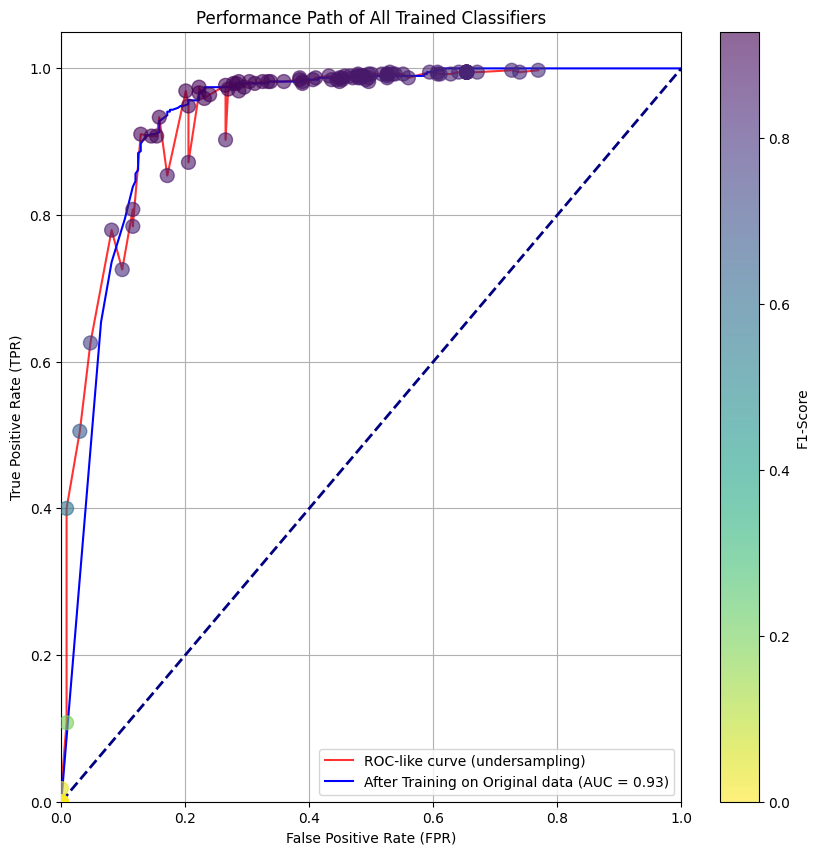

In [17]:
# (The rest of your code to plot the results remains the same)
plot_roc_connected_points(all_model_results)